## Librerías

In [1]:
import numpy as np 
import pandas as pd
import joblib
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
from mpl_toolkits.mplot3d import Axes3D
from skimage import feature, data, color 
import os
from tqdm import tqdm 
from skimage.transform import resize 
from skimage.io import imread
from sklearn.feature_extraction.image import PatchExtractor
from itertools import chain 
from scipy import stats 
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA 
from sklearn.naive_bayes import GaussianNB 
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split

#Metricas de performance
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
os.getcwd()

'/Users/rodrigobenitez/Documents/GitHub/ORT-AI/ML para AI/Obligatorio'

## Importar Caras y Fondos

In [3]:
face_suffix = '.pgm'

face_files = os.listdir('Faces/')
pgm_files = [filename for filename in face_files if filename.endswith(face_suffix)]

faces = []
for filename in tqdm(pgm_files):
  path = 'Faces/' + filename
  with open(path, 'rb') as pgmf:
      image = plt.imread(pgmf)
  faces.append(image)

100%|██████████| 12833/12833 [00:02<00:00, 5443.33it/s]


In [4]:
faces = np.array(faces)
faces.shape

(12833, 64, 64)

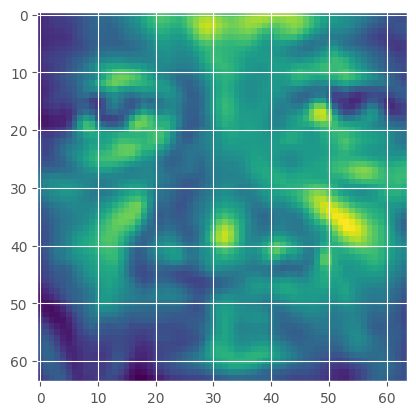

In [5]:
plt.imshow(faces[1])
plt.show()

In [6]:
background_suffix = '.png'

background_files = os.listdir('Generar_Fondos/generated_patches/')
png_files = [filename for filename in background_files if filename.endswith(background_suffix)]

backgrounds = []
for filename in tqdm(png_files):
  path = 'Generar_Fondos/generated_patches/' + filename
  with open(path, 'rb') as pgmf:
      image = plt.imread(pgmf)
  backgrounds.append(image)

100%|██████████| 12800/12800 [00:03<00:00, 4211.50it/s]


In [7]:
backgrounds = np.array(backgrounds)
backgrounds.shape

(12800, 64, 64)

In [8]:
IMG_SIZE = (64, 64)  # Tamaño al que se redimensionarán las imágenes

face_suffix = '.pgm'
face_dir = os.listdir('Faces/')
pgm_files = [filename for filename in face_dir if filename.endswith(face_suffix)]

face_suffix = '.png'
fondos_dir = os.listdir('Generar_Fondos/generated_patches/')
png_files = [filename for filename in fondos_dir if filename.endswith(face_suffix)]

positive_patches = []
for filename in tqdm(pgm_files):
    path = 'Faces/' + filename
    with open (path, 'rb') as pgmf:
        image = plt.imread(pgmf)
        img_resized = resize(image, IMG_SIZE, anti_aliasing=True)
        positive_patches.append(img_resized.flatten())

negative_patches = []
for filename in tqdm(png_files):
    path = 'Generar_Fondos/generated_patches/' + filename
    with open (path, 'rb') as pgmf:
        image = plt.imread(pgmf)
        img_resized = resize(image, IMG_SIZE, anti_aliasing=True)
        negative_patches.append(img_resized.flatten())
    

100%|██████████| 12800/12800 [00:05<00:00, 2319.66it/s]


In [9]:
positive_patches = np.array(positive_patches)
negative_patches = np.array(negative_patches)
negative_patches = (negative_patches*255).astype(np.uint8)
positive_patches = (positive_patches*255).astype(np.uint8)
print(positive_patches.shape)
print(negative_patches.shape)

(12833, 4096)
(12800, 4096)


In [10]:
# X = np.concatenate([faces, backgrounds])
# X = X.reshape(X.shape[0], -1) 
P = len(positive_patches)
X = np.array([im.flatten() for im in tqdm(chain(positive_patches, negative_patches), desc='Construyendo X')])
# X = (X*255).astype(np.uint8)
y = np.zeros(len(X))
y[:P] = 1 # 1 es positivo, 0 es negativo

Construyendo X: 25633it [00:00, 932039.27it/s]


In [11]:
y

array([1., 1., 1., ..., 0., 0., 0.])

In [12]:
# Separar en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [13]:
X

array([[ 93, 109, 118, ..., 227, 240, 225],
       [ 68,  72,  76, ...,  94,  89,  88],
       [105, 109, 112, ..., 208, 147,  36],
       ...,
       [216, 220, 220, ..., 208, 208, 211],
       [175, 171, 161, ..., 124, 125, 127],
       [214, 214, 213, ...,  81,  83,  83]], dtype=uint8)

## PCA

In [14]:
# Entrenar el modelo con PCA al conjunto de entrenamiento
# Aplicar PCA para reducir la dimensionalidad
pca = PCA(n_components=200)
X_train_pca = pca.fit(X_train)
X_train_pca_transform = pca.transform(X_train)
# X_train_pca_transform = pca.transform(X_train_pca)

In [15]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

# Obtener varianzas
var_explicada = X_train_pca.explained_variance_ratio_ 
var_acumulada = np.cumsum(var_explicada)

# Crear DataFrames para Plotly
df_var_explicada = pd.DataFrame({
    'Componente': range(1, len(var_explicada)+1),
    'Varianza': var_explicada
})

df_var_acumulada = pd.DataFrame({
    'Componente': range(1, len(var_acumulada)+1),
    'Varianza': var_acumulada
})

# Crear subplots usando Plotly Express
fig = make_subplots(rows=1, cols=2, subplot_titles=('Varianza explicada por componente', 'Varianza acumulada'))

# Varianza explicada
fig.add_trace(
    go.Bar(
        x=df_var_explicada['Componente'], 
        y=df_var_explicada['Varianza'], 
        name='Varianza explicada',
        marker_color='#1f77b4',  # Azul más oscuro
        opacity=0.8
    ),
    row=1, col=1
)

# Varianza acumulada
fig.add_trace(
    go.Bar(
        x=df_var_acumulada['Componente'], 
        y=df_var_acumulada['Varianza'], 
        name='Varianza acumulada',
        marker_color='#2ca02c',  # Verde más oscuro
        opacity=0.8
    ),
    row=1, col=2
)

# Agregar línea de 95% de varianza
fig.add_hline(
    y=0.95, 
    line_dash="dash", 
    line_color="red",
    line_width=2,
    row=1, 
    col=2
)

# Actualizar layout
fig.update_layout(
    height=500,
    width=1200,
    showlegend=True,
    title_text="Análisis de Varianza PCA",
    title_font_size=20,
    plot_bgcolor='white',
    paper_bgcolor='white',
    xaxis_title="Componente principal",
    yaxis_title="Proporción de varianza",
    xaxis2_title="Componente principal",
    yaxis2_title="Proporción de varianza",
    font=dict(size=12),
    margin=dict(t=100)
)

# Actualizar ejes para mejor visualización
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')

fig.show()

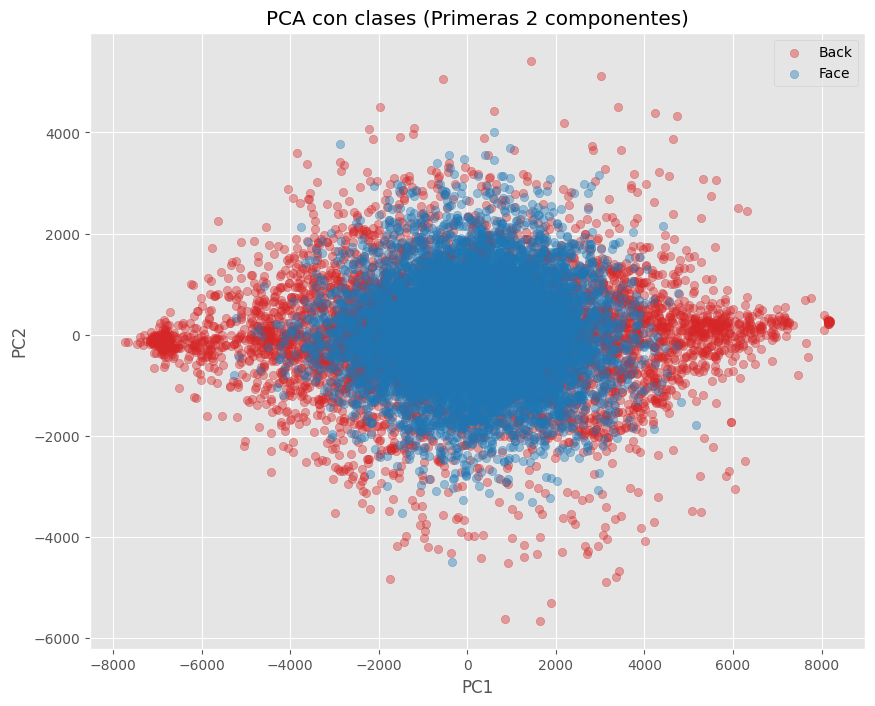

In [16]:
# Tomar solo las primeras dos componentes para graficar
X_plot = X_train_pca_transform[:, :2]

# Graficar con colores y leyenda
colors = ['tab:red', 'tab:blue']
labels = ['Back', 'Face']

plt.figure(figsize=(10, 8))
for class_value in [0, 1]:
    plt.scatter(X_plot[y_train == class_value, 0], 
                X_plot[y_train == class_value, 1], 
                c=colors[class_value], 
                label=labels[class_value], 
                alpha=0.4)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA con clases (Primeras 2 componentes)')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
joblib.dump(X_train_pca, 'models/pca_model.joblib')

['models/pca_model.joblib']

In [18]:
# Separar en conjuntos de entrenamiento y prueba
# X_train, X_test, y_train, y_test = train_test_split(x_transform, y, test_size=0.2, random_state=42)

X_test_pca = pca.transform(X_test)

In [19]:
print(X_train_pca_transform.shape)
print(X_test_pca.shape)
print(y_train.shape)
print(y_test.shape)

(17943, 200)
(7690, 200)
(17943,)
(7690,)


In [20]:
#Algorimtos de clasificacion
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from re import A


In [21]:
#X_train = X_train_pca_transform
#
#X_test = X_test_pca

### KNN

In [22]:
# Elegimos el k
k = 3

In [23]:
knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
knn.fit(X_train_pca_transform, y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=3)

In [26]:
y_train_pred =knn.predict(X_train_pca_transform)
y_test_pred = knn.predict(X_test_pca)

print('Accuracy train:',accuracy_score(y_train,y_train_pred))
print('Accuracy test: ',accuracy_score(y_test,y_test_pred))

Accuracy train: 0.9696817700496015
Accuracy test:  0.9469440832249675


In [27]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97      8990
         1.0       1.00      0.94      0.97      8953

    accuracy                           0.97     17943
   macro avg       0.97      0.97      0.97     17943
weighted avg       0.97      0.97      0.97     17943



In [28]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

         0.0       0.91      0.99      0.95      3810
         1.0       0.99      0.90      0.95      3880

    accuracy                           0.95      7690
   macro avg       0.95      0.95      0.95      7690
weighted avg       0.95      0.95      0.95      7690



In [71]:
joblib.dump(knn, 'models/knn_model.joblib')

['models/knn_model.joblib']

## HOG

In [57]:
from skimage.feature import hog
from sklearn.svm import LinearSVC


In [44]:
IMG_SIZE = (64, 64)  # Tamaño al que se redimensionarán las imágenes

face_suffix = '.pgm'
face_dir = os.listdir('Faces/')
pgm_files = [filename for filename in face_dir if filename.endswith(face_suffix)]

face_suffix = '.png'
fondos_dir = os.listdir('Generar_Fondos/generated_patches/')
png_files = [filename for filename in fondos_dir if filename.endswith(face_suffix)]

positive_patches = []
for filename in tqdm(pgm_files):
    path = 'Faces/' + filename
    with open (path, 'rb') as pgmf:
        image = plt.imread(pgmf)
        image_norm = (image*255).astype(np.uint8)
        hog_feature = hog(image_norm, feature_vector=True)
        positive_patches.append(hog_feature)

negative_patches = []
for filename in tqdm(png_files):
    path = 'Generar_Fondos/generated_patches/' + filename
    with open (path, 'rb') as pgmf:
        image = plt.imread(pgmf)
        image_norm = (image*255).astype(np.uint8)
        hog_feature = hog(image_norm, feature_vector=True)
        negative_patches.append(hog_feature)

100%|██████████| 12800/12800 [00:09<00:00, 1318.10it/s]


In [46]:
image_norm

array([[214, 214, 213, ..., 219, 221, 221],
       [214, 214, 213, ..., 219, 221, 221],
       [216, 216, 215, ..., 220, 223, 223],
       ...,
       [ 77,  77,  69, ...,  74,  76,  76],
       [ 69,  69,  64, ...,  81,  83,  83],
       [ 69,  69,  64, ...,  81,  83,  83]], dtype=uint8)

In [53]:
P = len(positive_patches)
X = np.array(positive_patches + negative_patches)
# X = (X*255).astype(np.uint8)
y = np.zeros(len(X))
y[:P] = 1 # 1 es positivo, 0 es negativo

In [54]:
X

array([[0.11646401, 0.03128126, 0.00558129, ..., 0.        , 0.01059255,
        0.03064134],
       [0.05215952, 0.01875931, 0.08044653, ..., 0.03149585, 0.09934855,
        0.13186444],
       [0.09338918, 0.01034122, 0.00889002, ..., 0.00365123, 0.01220339,
        0.15453749],
       ...,
       [0.3218401 , 0.16561955, 0.04443518, ..., 0.06822025, 0.10878039,
        0.18588596],
       [0.21826724, 0.25334911, 0.13243198, ..., 0.01130234, 0.00650805,
        0.02261462],
       [0.1875189 , 0.03962759, 0.18356575, ..., 0.03862197, 0.00812979,
        0.        ]])

In [55]:
y

array([1., 1., 1., ..., 0., 0., 0.])

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [58]:
# Entrenar modelo
clf = LinearSVC()
clf.fit(X_train, y_train)

LinearSVC()

In [59]:
# Evaluar
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9945387165984007
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      2527
         1.0       0.99      1.00      0.99      2600

    accuracy                           0.99      5127
   macro avg       0.99      0.99      0.99      5127
weighted avg       0.99      0.99      0.99      5127



In [60]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[2511   16]
 [  12 2588]]


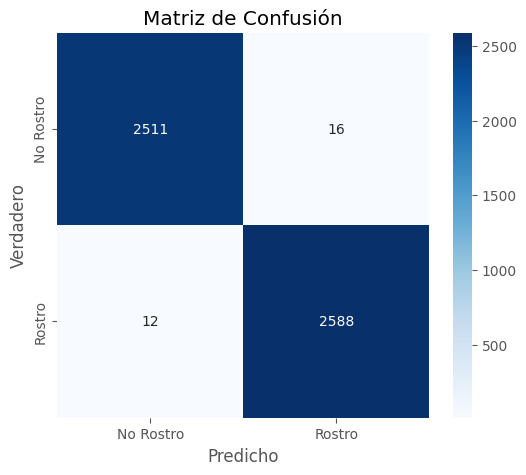

In [62]:
import seaborn as sns

# Visualizar la matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Rostro', 'Rostro'], yticklabels=['No Rostro', 'Rostro'])
plt.xlabel('Predicho')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión')
plt.show()

In [63]:
joblib.dump(clf, 'models/hog_model.joblib')

['models/hog_model.joblib']